In [1]:
from data_import import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# LOAD THE DATA AND SPLIT UP THINGS
images, labels, classes, filepaths = read_csv_as_numpy() 

X_tr, X_val, Y_tr, Y_val, train_filepaths, val_filepaths = train_test_split(
        images, labels, filepaths, test_size=0.2
    )

print(X_tr.shape)

(10212, 625)


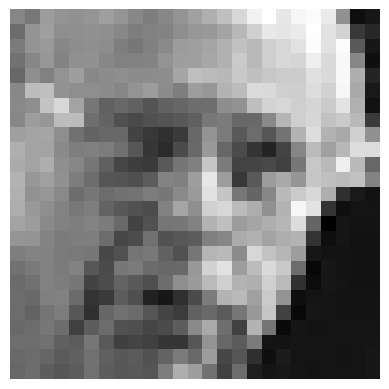

Filepath: ./images/Edward_Johnson_0001.jpg
Label: NEUTRAL


In [2]:
# Reshape the flattened image back to 50x50
image_reshaped = X_tr[60, :].reshape(25, 25)

# Display the image
plt.imshow(image_reshaped, cmap='gray')
plt.axis('off')  # Turn off axis
plt.show()

# Optional: Print the file path and label
print("Filepath:", train_filepaths[60])
print("Label:", classes[Y_tr[60]])

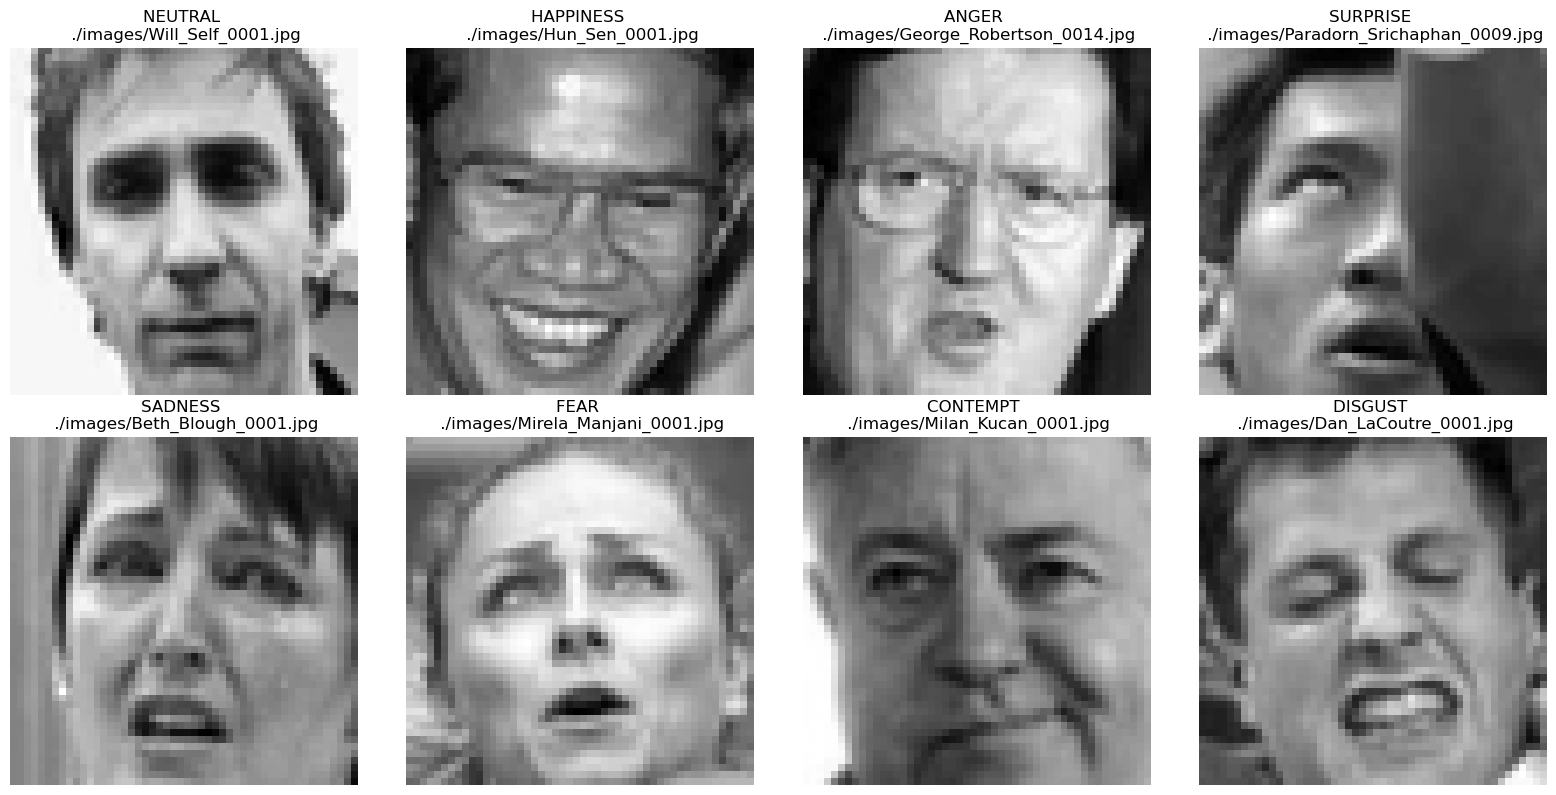

In [8]:
# Dictionary to store one sample per class
unique_samples = {}

# Collect one sample per class
for i in range(len(Y_tr)):
    label = classes[Y_tr[i]]  # Get the class name
    if label not in unique_samples:
        unique_samples[label] = (X_tr[i], train_filepaths[i])
        if len(unique_samples) == 8:  # Stop when we have 8 samples
            break

# Number of rows and columns
rows, cols = 2, 4

# Create a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Display each image
for ax, (label, (image, filepath)) in zip(axes, unique_samples.items()):
    ax.imshow(image.reshape(50, 50), cmap='gray')
    ax.set_title(f'{label} \n {filepath}')
    ax.axis('off')  # Hide axes for clarity
    

# Hide any unused subplots
for ax in axes[len(unique_samples):]:
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report


# TRAIN MODEL

# sklearn's mlp classifier requires flat data, so we flattened it

errors = []


# nn = MLPClassifier(hidden_layer_sizes=[128, 64],
#                     activation='relu',
#                     solver='sgd',
#                     batch_size = 256,
#                     learning_rate='constant',
#                     learning_rate_init=0.001)

nn = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=200)


nn.fit(X_tr, Y_tr)
error_curve_train = nn.loss_curve_

# plt.plot(error_curve_train)
# plt.xlim(0, 100)
# plt.show()

# y_pred = nn.predict(X_val)
# print(len(y_pred))
err = 1 - nn.score(X_val, Y_val)
print(f"Error: {err}")
# print(f"Predicted: {y_pred}   Actual: {Y_val}")

# print(classification_report(Y_val, y_pred))

# GRAPH

Error: 0.373286329808069


In [3]:
# RELOAD AND STRUCTURE DATA FOR CNN
import tensorflow as tf
X_tr, Y_tr, X_val, Y_val, classes, filepaths = read_csv_as_numpy()


X_tr = np.reshape(X_tr, (-1, 50, 50, 1))
# Y_tr = np.reshape(Y_tr, (-1, 50, 50, 1))
X_val = np.reshape(X_val, (-1, 50, 50, 1))
# Y_val = np.reshape(Y_val, (-1, 50, 50, 1))
X_tr = X_tr.astype('float32') / 255.0  # Scale to [0, 1]
X_val = X_val.astype('float32') / 255.0
# X_tr = X_tr[..., tf.newaxis]  # Shape: (num_samples, 50, 50, 1)
# X_val = X_val[..., tf.newaxis]


print(X_tr.shape)
print(X_val.shape)

from tensorflow.keras.utils import to_categorical
num_classes = len(set(Y_tr))
Y_tr = to_categorical(Y_tr, num_classes)
Y_val = to_categorical(Y_val, num_classes)

(10212, 50, 50, 1)
(2553, 50, 50, 1)


In [ ]:
# CNN
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


# Example data setup: replace with your own dataset
# Assuming `X_train`, `X_test`, `y_train`, `y_test` are ready

# Reshape data
# X_tr = np.reshape(X_tr, (-1, 50, 50, 1))
# X_val = np.reshape(X_val, (-1, 50, 50, 1))


# Normalize the image pixel values
# X_tr = X_tr.astype('float32') / 255.0  # Scale to [0, 1]
# X_val = X_val.astype('float32') / 255.0

# If images are grayscale, add a channel dimension


# If labels are integers (e.g., 0, 1, ..., num_classes-1), convert to one-hot

def create_model():
    input_shape=(50, 50, 1)
    num_classes=8

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model 

start = time.time()
# Build the CNN model
model = create_model()

# L2 Regularized model
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1), kernel_regularizer=l2(0.01)),
#     MaxPooling2D(pool_size=(2, 2)),
#     Flatten(),
#     Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
#     Dense(8, activation='softmax')
# ])

# Compile the model
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Train the model
# datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )
# datagen.fit(X_tr)


# Train the model
start_time = time.time()
epochs = 10
batch_size = 32

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

training_time = time.time() - start_time

history = model.fit(
    X_tr, 
    Y_tr,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1 
)

# Evaluate the model
loss, accuracy = model.evaluate(X_val, Y_val)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

end = time.time()
print(f"Training took {end-start} seconds.")



Epoch 1/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.4826 - loss: 1.0545 - val_accuracy: 0.5280 - val_loss: 1.0838 - learning_rate: 0.0100
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.4942 - loss: 0.9580 - val_accuracy: 0.5280 - val_loss: 0.9611 - learning_rate: 0.0100
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.4983 - loss: 0.9581 - val_accuracy: 0.5292 - val_loss: 1.0734 - learning_rate: 0.0100
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5236 - loss: 0.9504 - val_accuracy: 0.5139 - val_loss: 0.9895 - learning_rate: 0.0100
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5196 - loss: 0.9499 - val_accuracy: 0.5272 - val_loss: 0.9612 - learning_rate: 0.0100
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5193 - loss: 0.9473 - val_accuracy: 0.5280 - val_loss: 0.9623 - learning_rate: 0.0100
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5160 - loss: 0.